In [10]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina

print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [2]:
scoobi.home_block(client0)

In [4]:
scoobi.move_block_out(client0)

In [11]:
reload(scoobi)
xc, yc = (4600, 3400)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [15]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')

# Do the normalization

In [20]:
scoobi.move_psf(50, 0, client0)

In [23]:
scoobi.move_psf(0, -50, client0)

In [24]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [25]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [26]:
reload(scoobi)
I.set_fib_atten(30, client)

Set the fiber attenuation to 30.0


INFO:utils:Got semaphore index 1.


27985.82


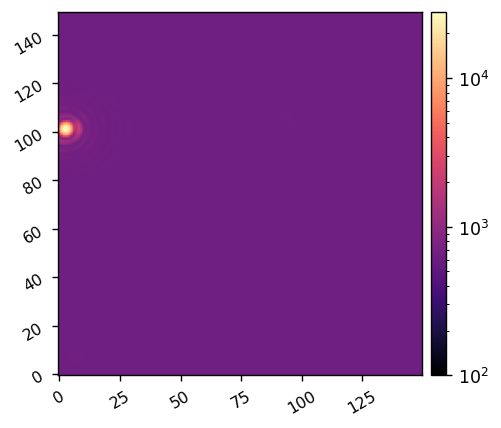

In [27]:
I.NSCICAM = 200
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [28]:
I.ref_psf_params = {
    'ref_psf':copy.copy(ref_psf),
    'Imax': copy.copy(xp.max(ref_psf)),
    'texp': 0.000120, 
    'atten': 30,
    'gain': 120,
}
print(I.ref_psf_params)
utils.save_pickle(f'../data/llowfsc+iefc/{today}_ref_psf_params.pkl', I.ref_psf_params)

{'ref_psf': array([[638.58, 642.88, 639.9 , ..., 640.4 , 637.98, 641.44],
       [639.28, 638.24, 640.46, ..., 639.24, 640.4 , 638.24],
       [639.94, 639.36, 639.08, ..., 640.84, 639.32, 638.22],
       ...,
       [639.88, 640.1 , 640.02, ..., 638.72, 639.74, 640.16],
       [640.68, 638.88, 637.88, ..., 638.1 , 638.32, 639.8 ],
       [639.56, 640.16, 639.68, ..., 639.7 , 638.82, 639.88]]), 'Imax': array(27985.82), 'texp': 0.00012, 'atten': 30, 'gain': 120}
Saved data to:  ../data/llowfsc+iefc/20241216_ref_psf_params.pkl


# Move back onto the vortex and adjust exposure times

In [60]:
scoobi.move_psf(2, 0, client0)

In [54]:
scoobi.move_psf(0, -1, client0)

In [155]:
I.reset_dm()

In [40]:
I.set_fib_atten(5, client)

Set the fiber attenuation to 5.0


In [87]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


In [42]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


# Make a function to adjust bias on the camera
camsci.blacklevel.target

In [62]:
reload(scoobi)
scoobi.move_block_in(client0)

Saved data to:  ../data/llowfsc+iefc/20241216_camsci_dark_frame_1.pkl


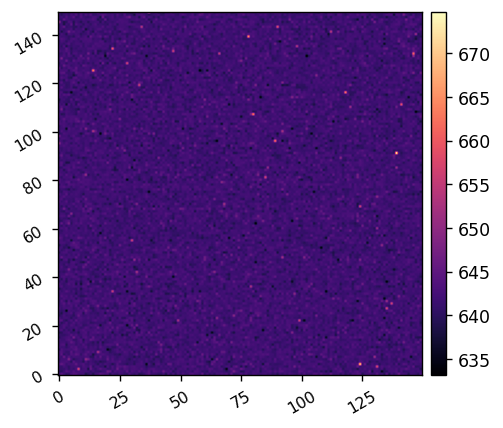

In [63]:
I.NSCICAM = 200
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
utils.save_pickle(f'../data/llowfsc+iefc/{today}_camsci_dark_frame_1.pkl', dark_frame)
I.df = copy.copy(dark_frame)

# dark_frame = utils.load_pickle(f'../data/llowfsc+iefc/{today}_camsci_dark_frame_1.pkl')
# I.df = copy.copy(dark_frame)

imshow1(dark_frame)

In [64]:
reload(scoobi)
scoobi.move_block_out(client0)

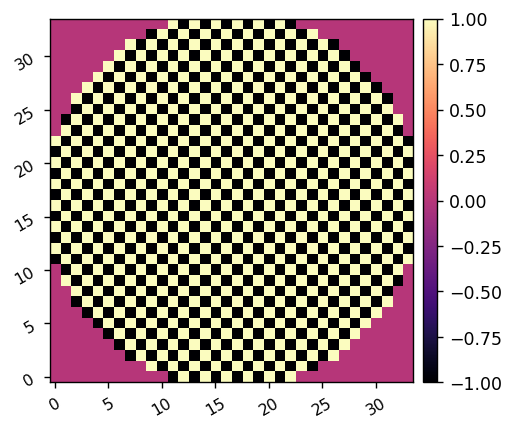

In [66]:
reload(scoobi.utils)
waffle_command = scoobi.utils.create_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

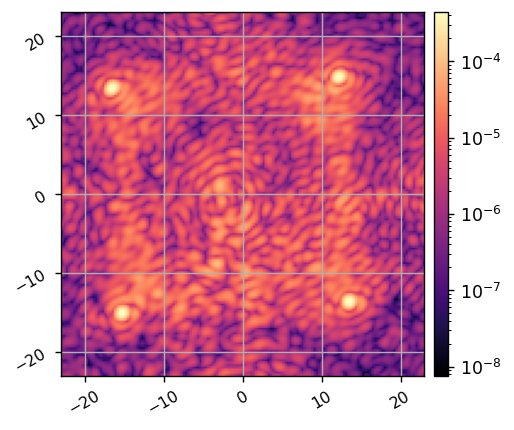

In [67]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

I.NSCICAM = 100
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamDc, grid=True)

Centroids:
 [[ 24.75065559  25.54730163]
 [ 20.64297751 118.18978536]
 [114.06602488 122.85876813]
 [118.30668103  30.16906922]
 [ 24.75065559  25.54730163]]


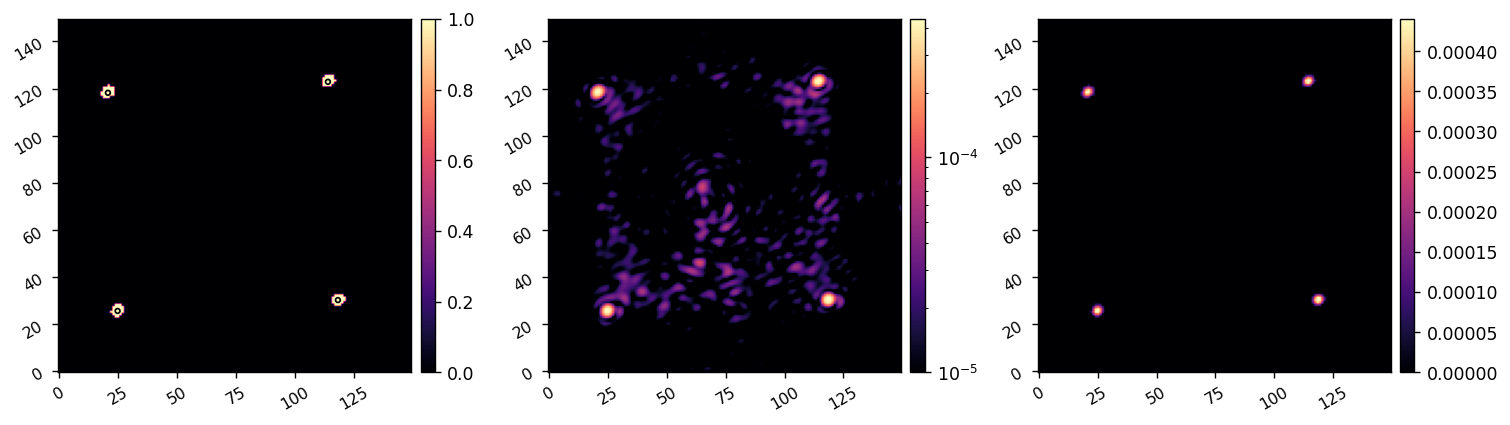

Angle:  87.28811334900533
Measured center in X:  69.42658251500896
Measured center in Y:  74.22291032422521
Required shift in X:  6.0
Required shift in Y:  1.0


In [68]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamDc, im_thresh=7e-5, r_thresh=16)

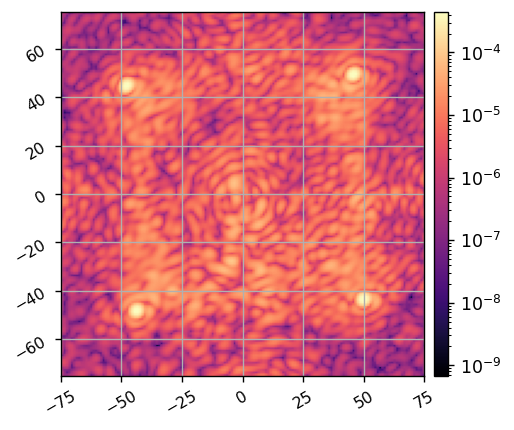

In [69]:
I.Nframes = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift

I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

In [65]:
I.zero_dm()

# Choose modes and probes for iEFC

In [70]:
reload(lina.utils)

iwa = 2.5
owa = 11
rotation = 180
control_mask = lina.utils.create_annular_focal_plane_mask(
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    iwa, 
    owa, 
    edge=iwa, 
    rotation=rotation,
)

5.182562157357163e-06


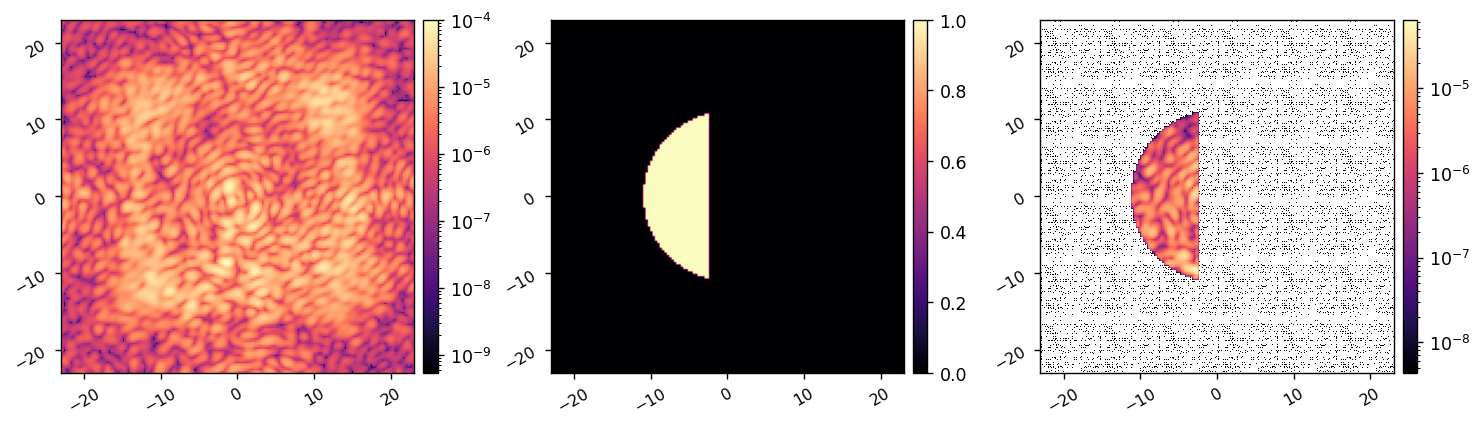

In [88]:
I.zero_dm()
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True
# I.set_zwo_exp_time(0.0005, client0)

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

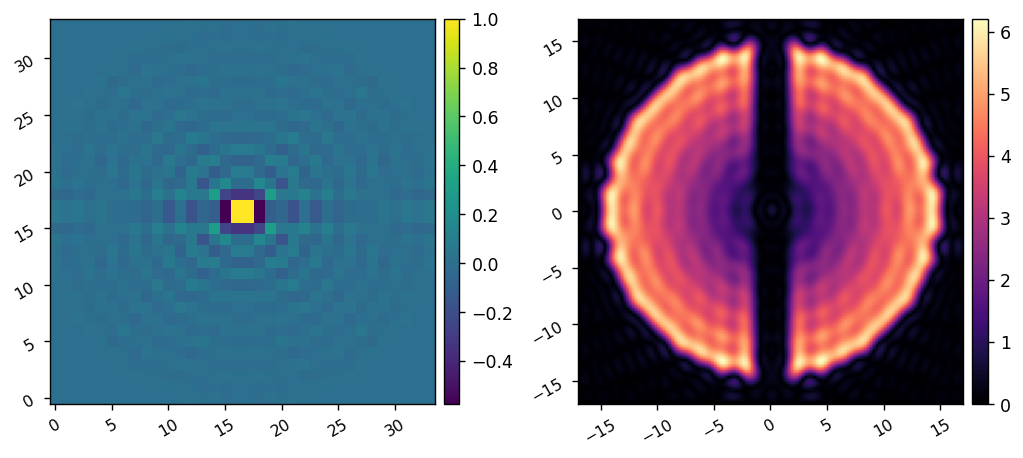

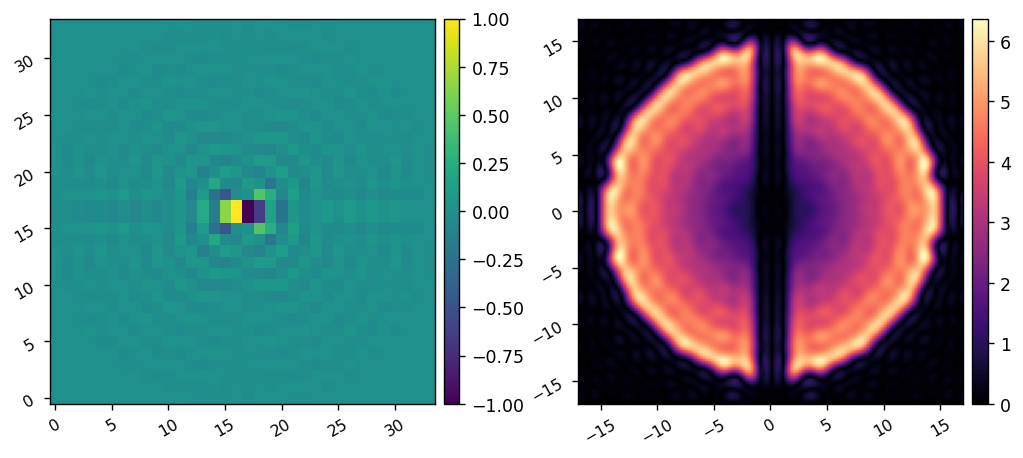

In [75]:
reload(lina.utils)
probe_iwa = 2
probe_owa = 14

probe_modes = lina.utils.create_fourier_probes(
    xp.array(I.dm_mask), 
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    probe_iwa, 
    probe_owa, 
    rotation=rotation,
    fourier_sampling=0.75, 
    shifts=None, 
    nprobes=2,
    use_weighting=True, 
    plot=True,
)

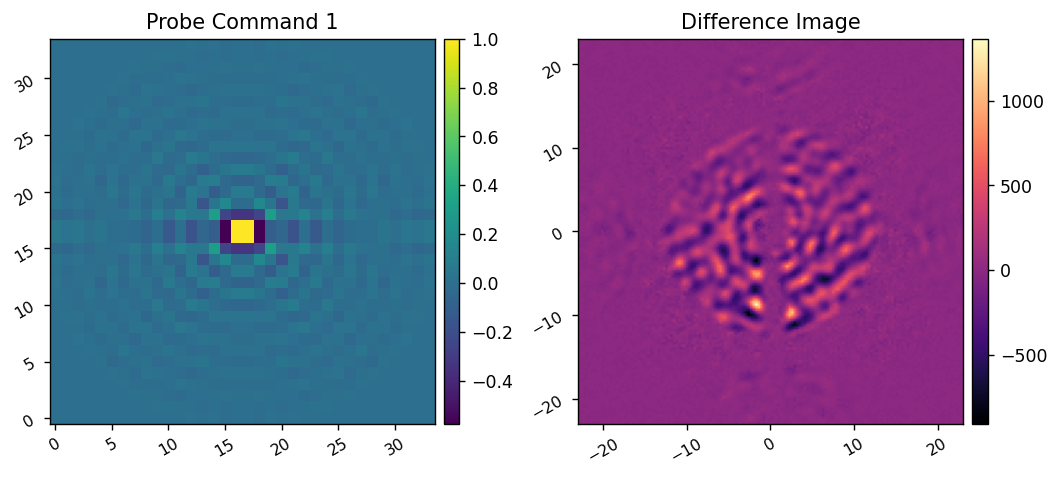

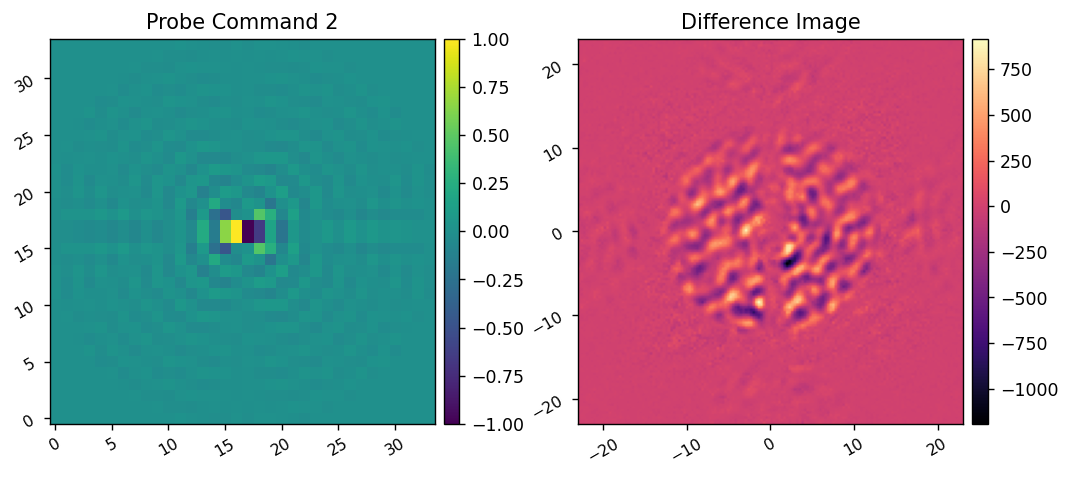

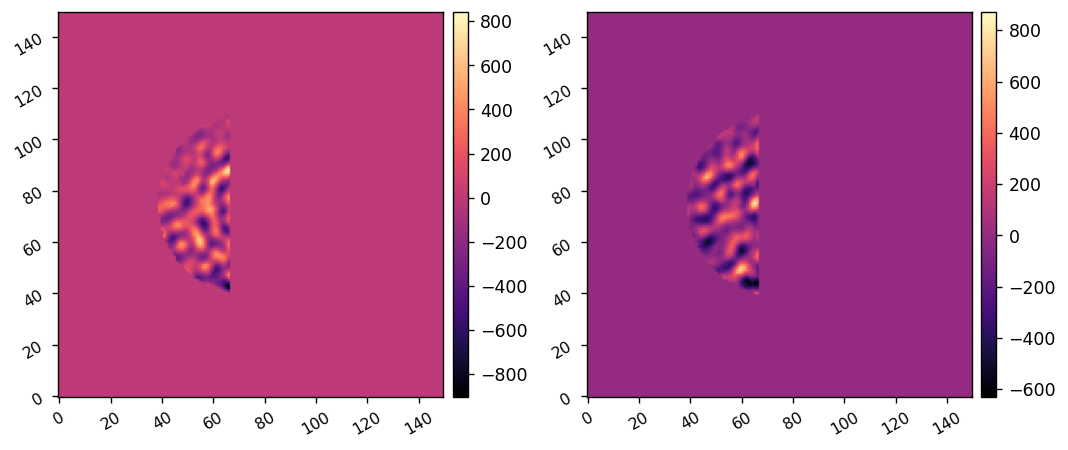

In [78]:
reload(lina.iefc)

time.sleep(3)
I.NSCICAM = 30
I.subtract_dark = False
I.return_ni = True

diff_ims = lina.iefc.take_measurement(
    I, 
    probe_modes, 
    3e-9, 
    plot=True,
)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

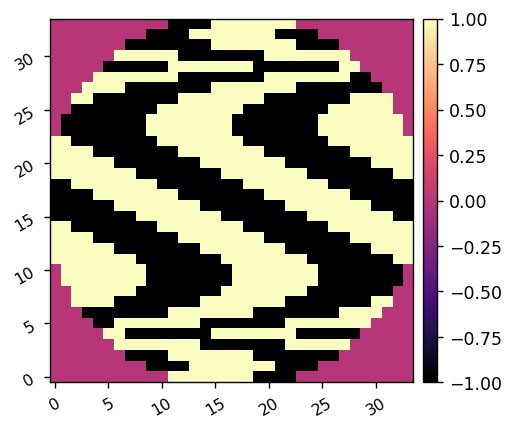

In [79]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(I.dm_mask))
imshow1(calib_modes[8])


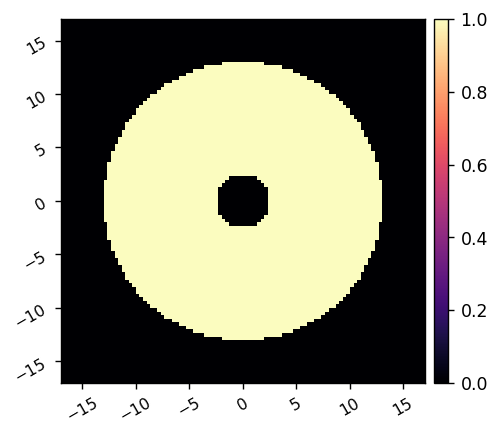

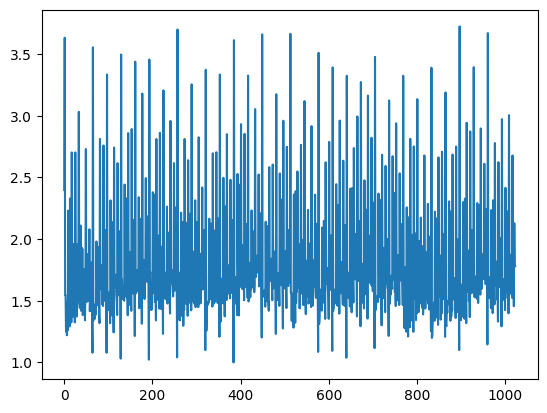

[1.26141126 2.2314004  1.69366311 1.7770875 ]


In [82]:
reload(lina.iefc)
scale_factors = lina.iefc.compute_hadamard_scale_factors(calib_modes, scale_exp=1/5, scale_thresh=4, oversamp=3, plot=True)
print(scale_factors[8:12])

In [84]:
I.zero_dm()

In [90]:
reload(lina.iefc)
I.zero_dm()

probe_amp = 3e-9
calib_amp = 2.5e-9

I.NSCICAM = 10
I.return_ni = True
I.subtract_dark = False
I.dm_delay = I.texp * 3
print(I.dm_delay)

# time.sleep(2)
response_matrix, response_cube = lina.iefc.calibrate(
    I, 
    control_mask, 
    probe_amp, 
    probe_modes, 
    calib_amp, 
    calib_modes, 
    scale_factors=scale_factors, 
#  calib_amp, calib_modes[100:110], 
#  scale_factors=scale_factors[100:110], 
#  calib_amp, calib_modes[8:12], 
#  scale_factors=scale_factors[8:12], 
    return_all=True,
)

0.003
Calibrating iEFC...
	Calibrated mode 1024/1024 in 684.150s
Calibration complete.


In [91]:
lina.utils.save_pickle(f'../data/llowfsc+iefc/{today}_iefc_hadamard_jac_cube_1.pkl', response_cube)

Saved data to:  ../data/llowfsc+iefc/20241216_iefc_hadamard_jac_cube_1.pkl


In [92]:
response_cube = utils.load_pickle(f'../data/llowfsc+iefc/{today}_iefc_hadamard_jac_cube_1.pkl')
response_matrix = response_cube[:, :, control_mask.ravel()].reshape(1024, -1).T

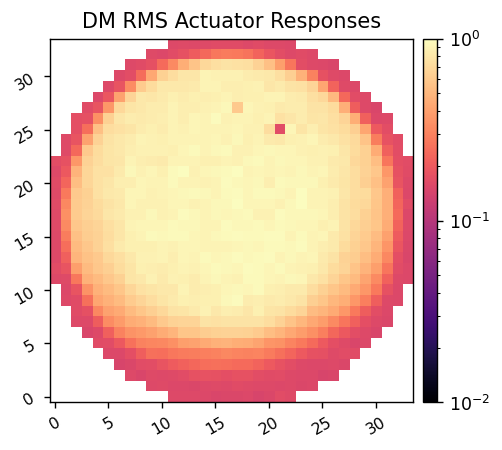

In [93]:
dm_response_map = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes.reshape(1024, -1))), axis=0))
dm_response_map = dm_response_map.reshape(I.Nact,I.Nact) / xp.max(dm_response_map)
imshow1(dm_response_map, 'DM RMS Actuator Responses', lognorm=True, vmin=1e-2)

In [94]:
cm1 = lina.utils.beta_reg(response_matrix, -2.5)
cm2 = lina.utils.beta_reg(response_matrix, -5)


In [95]:
I.zero_dm()
data = {
    'images':[ref_coro_im],
    'commands':[],
    'del_commands':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
    'probes':probe_modes,
}

0.22499999999999998
Running iEFC...
	Closed-loop iteration 16 / 18


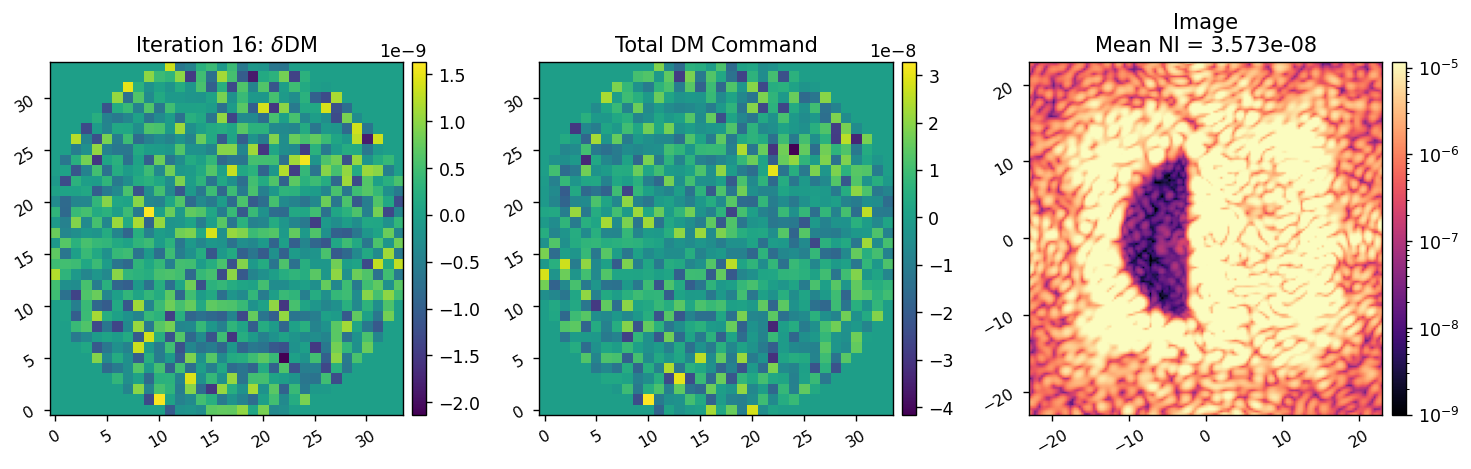

	Closed-loop iteration 17 / 18


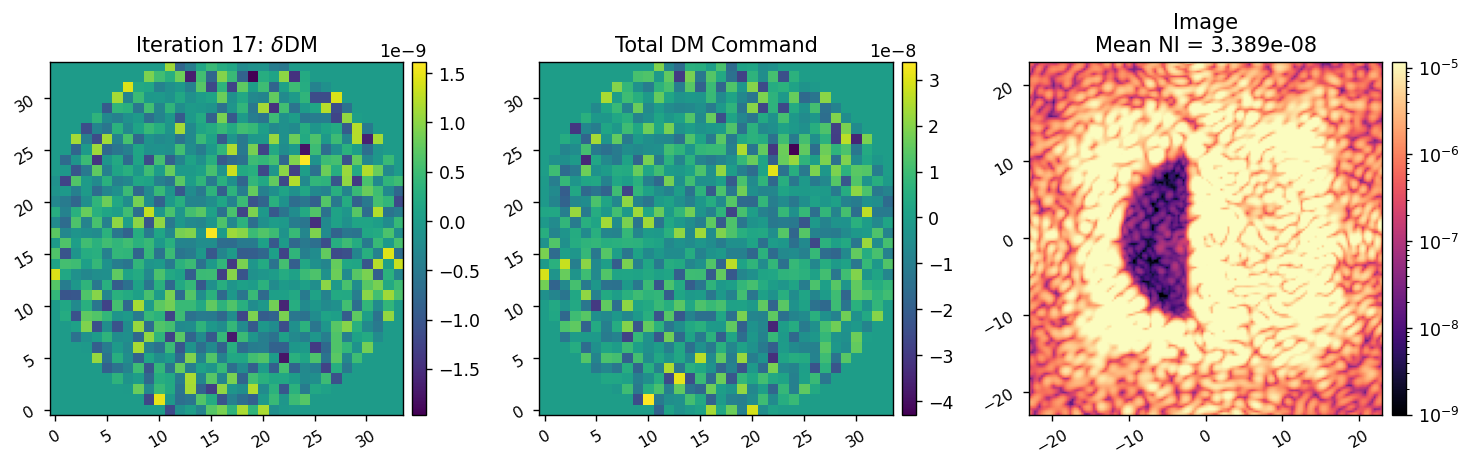

	Closed-loop iteration 18 / 18


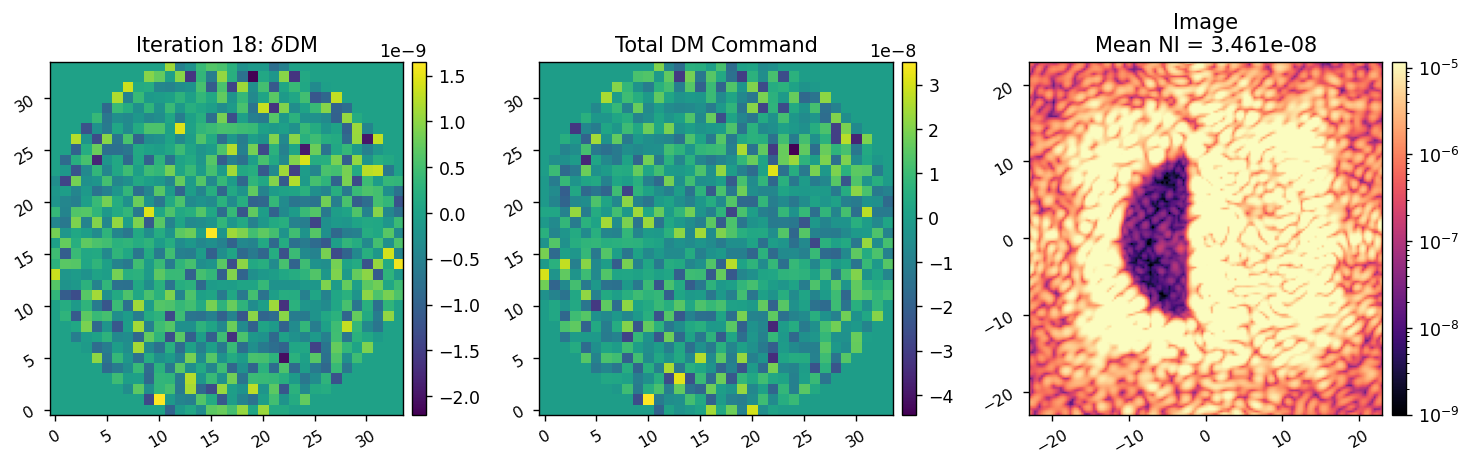

Closed loop for given control matrix completed in 34.452s.


In [108]:
reload(lina.utils)
reload(lina.iefc)

probe_amp = 5e-9
probe_amp = 4e-9
probe_amp = 3e-9
# probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
probe_amp = 1e-9
# probe_amp = 0.75e-9
# probe_amp = 0.5e-9

I.NSCICAM = 20
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

data = lina.iefc.run(
    I,
    data,
    cm1,
    # cm2,
    probe_modes, 
    probe_amp, 
    calib_modes,
    control_mask,
    num_iterations=3,
    loop_gain=0.75, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    plot_probes=False,
    plot_radial_contrast=False,
)

In [97]:
I.texp

0.001

In [98]:
# I.set_fib_atten(5, client)
I.set_zwo_exp_time(0.075, client0, delay=1)
I.set_zwo_gain(120, client0)

Set the ZWO exposure time to 7.50e-02s
Set the ZWO gain setting to 120.0


In [99]:
reload(scoobi)
scoobi.move_block_in(client0)

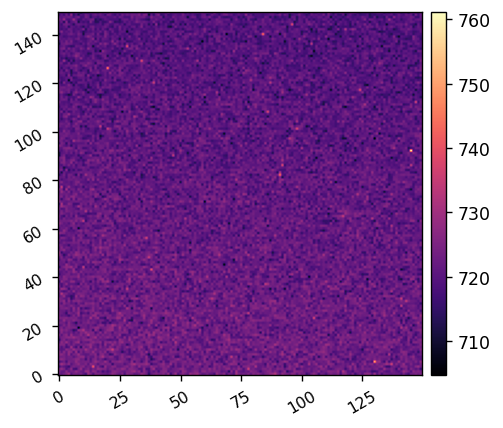

In [100]:
I.NSCICAM = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

In [101]:
reload(scoobi)
scoobi.move_block_out(client0)

1.3416770438117335e-07


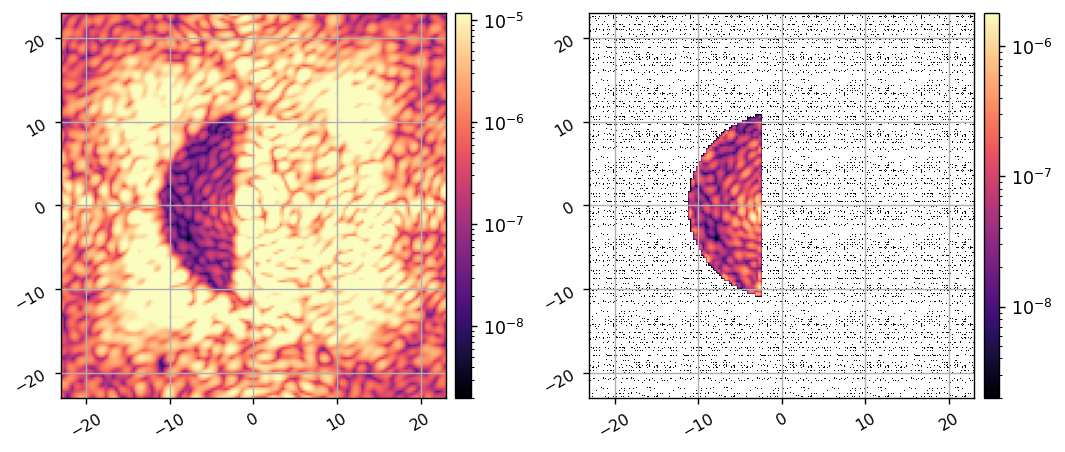

In [103]:
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im, grid=True, lognorm=True, pxscl=I.psf_pixelscale_lamDc)

# Shrink control region

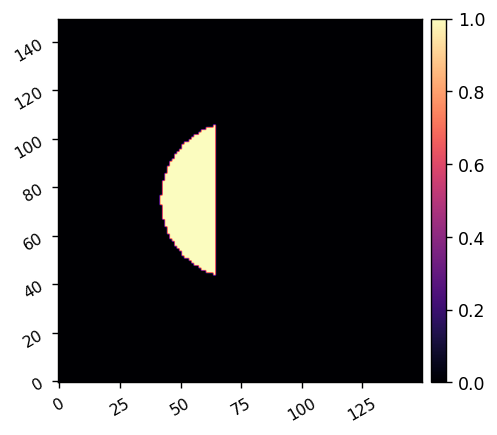

In [109]:
new_iwa = 3
new_owa = 10
new_control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, new_iwa, new_owa, edge=new_iwa, rotation=rotation)
imshow1(new_control_mask)

In [110]:
new_response_matrix = response_cube[:, :, new_control_mask.ravel()].reshape(1024, -1).T
new_response_matrix.shape

(2044, 1024)

In [111]:
cm1 = lina.utils.beta_reg(new_response_matrix, -2)
cm2 = lina.utils.beta_reg(new_response_matrix, -3.5)
cm3 = lina.utils.beta_reg(new_response_matrix, -5)

0.22499999999999998
Running iEFC...
	Closed-loop iteration 31 / 33


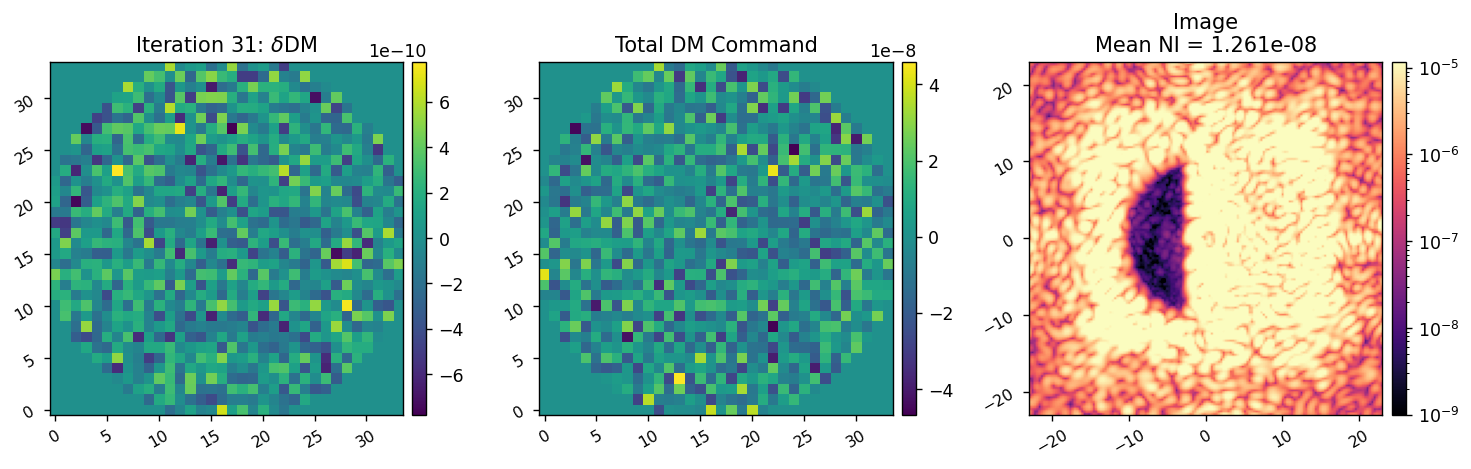

	Closed-loop iteration 32 / 33


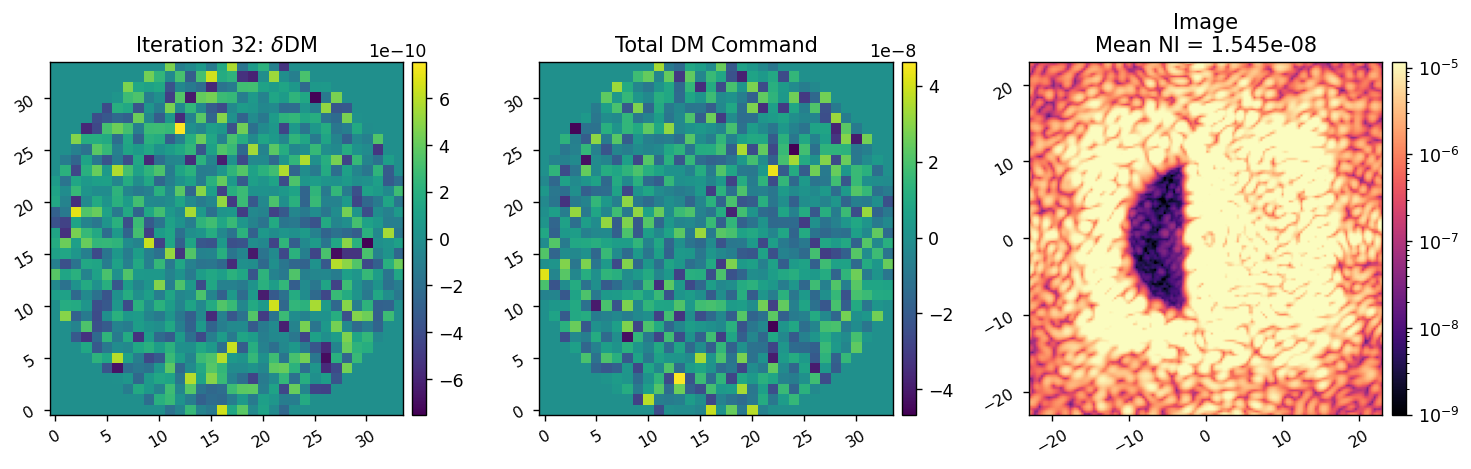

	Closed-loop iteration 33 / 33


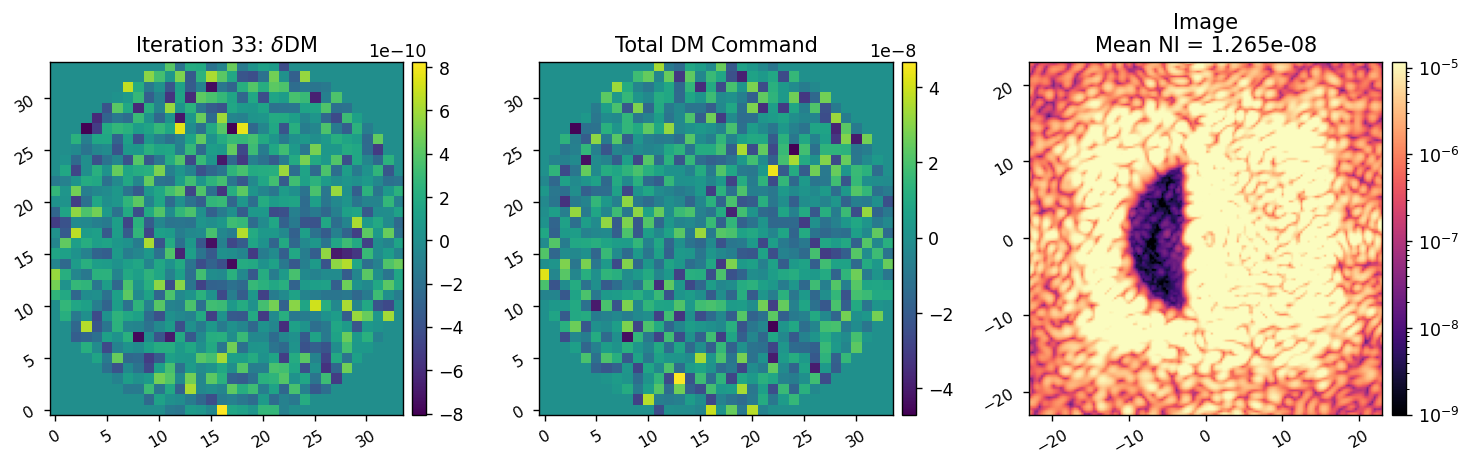

Closed loop for given control matrix completed in 35.257s.


In [118]:
reload(lina.utils)
reload(lina.iefc)


probe_amp = 5e-9
probe_amp = 4e-9
probe_amp = 3e-9
# probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
probe_amp = 1e-9
probe_amp = 0.75e-9
# probe_amp = 0.5e-9

I.NSCICAM = 20
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

data = lina.iefc.run(
    I,
    data,
    cm1,
    # cm2,
    # cm3,
    probe_modes, probe_amp, 
    calib_modes,
    new_control_mask,
    num_iterations=3,
    loop_gain=0.75, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    plot_probes=False,
    plot_radial_contrast=False,
)

1.224629534649882e-08


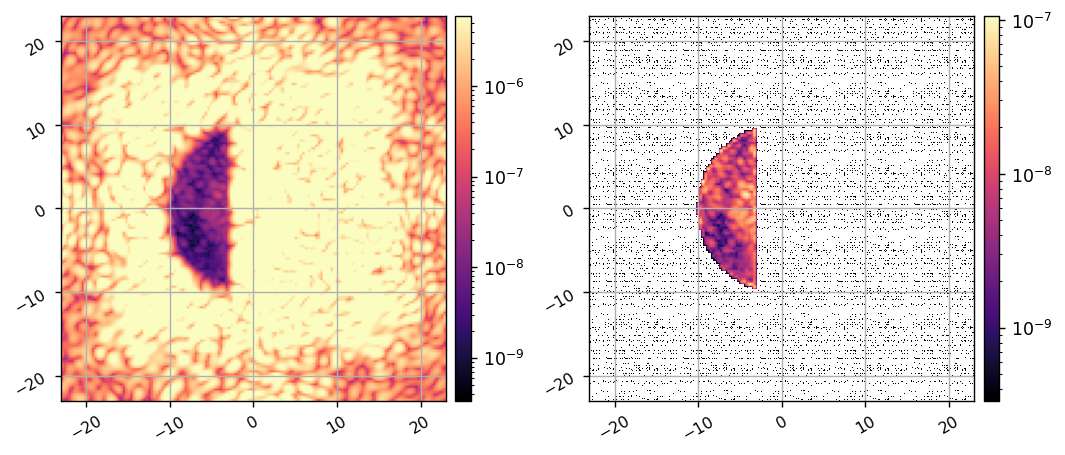

In [237]:
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[new_control_mask]))
imshow2(coro_im, new_control_mask * coro_im, grid=True, lognorm=True, pxscl=I.psf_pixelscale_lamDc)

In [116]:
data.update({'control_mask_2':new_control_mask})
lina.utils.save_pickle(f'../data/llowfsc+iefc/{today}_iefc_run_180_1.pkl', data)


Saved data to:  ../data/llowfsc+iefc/20241216_iefc_run_180_1.pkl


# Test a single iteration of iEFC. 

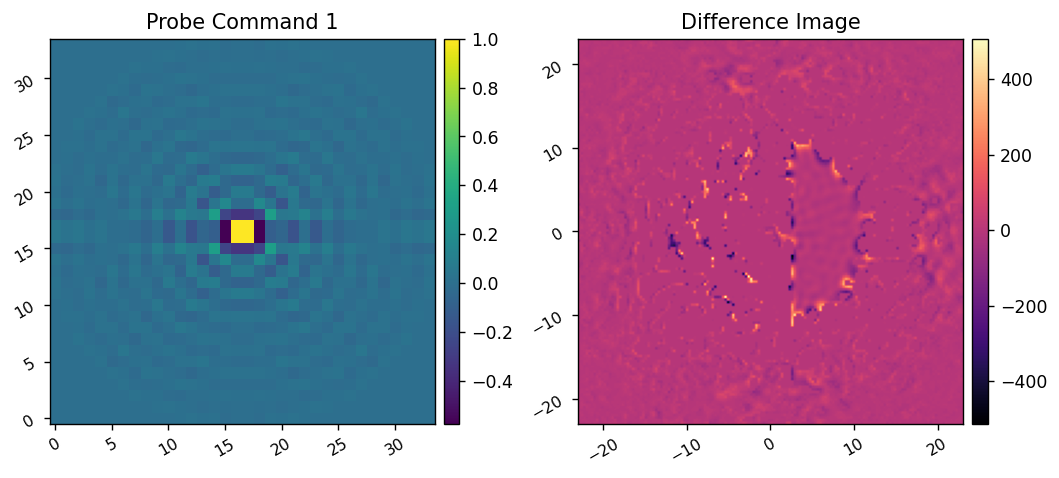

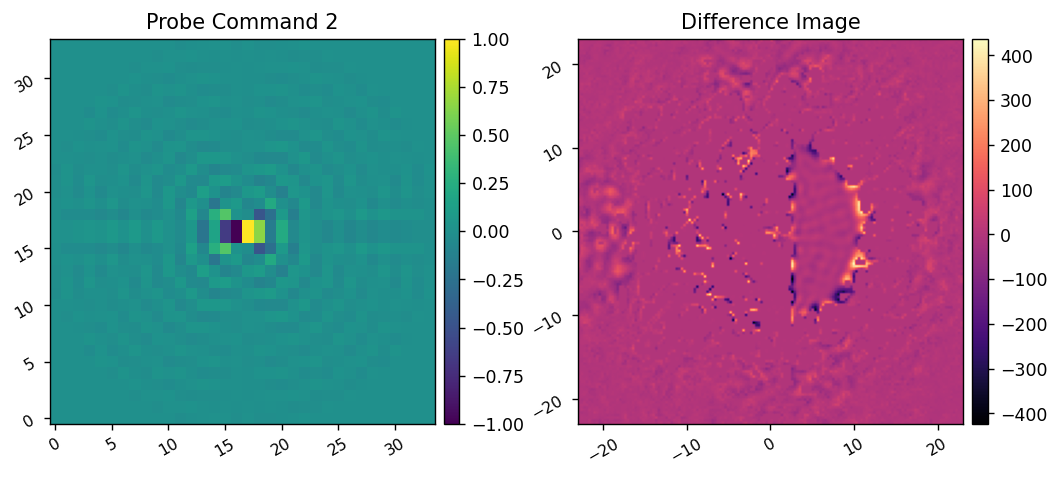

(1024, 2044) (2044,)


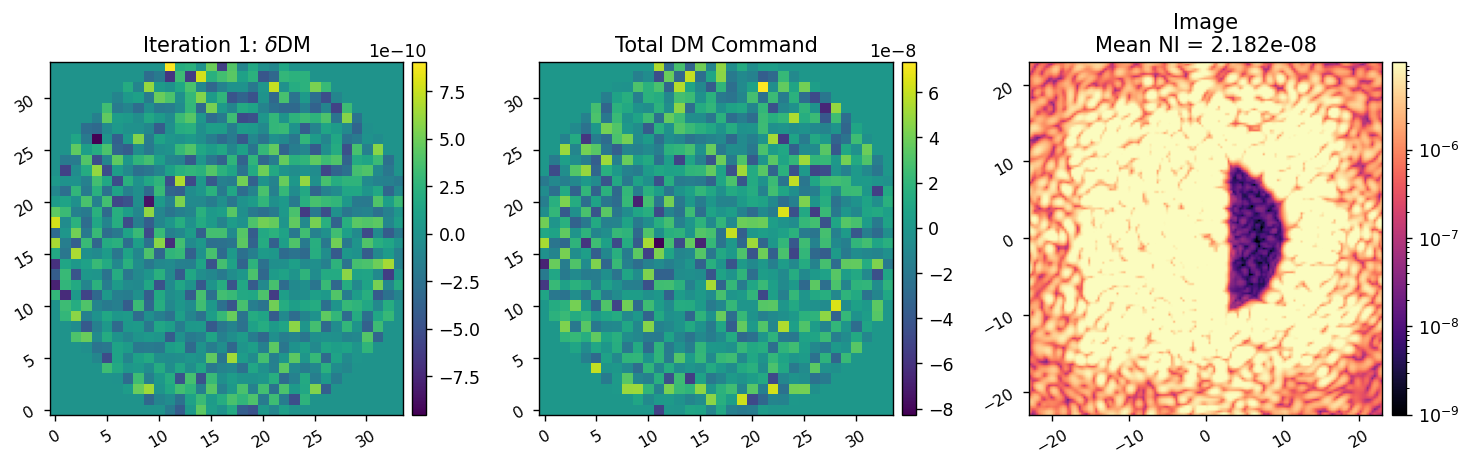

In [142]:
reload(lina.iefc)
probe_amp = 0.75e-9
modal_matrix = calib_modes.reshape(1024, -1)
cm = lina.utils.beta_reg(new_response_matrix, -2.5)

lina.iefc.single_iteration(
    I, 
    probe_modes, 
    probe_amp, 
    cm, 
    modal_matrix, 
    new_control_mask, 
    gain=0.5, 
    plot=True, 
    plot_probes=True,
)

# Define a continuoius iEFC process and run it in the background.

In [119]:
reload(lina.iefc)
iefc_interval = 60
I.dm_delay = 2*I.texp

probe_amp = 0.75e-9
modal_matrix = calib_modes.reshape(1024, -1)
cm = lina.utils.beta_reg(new_response_matrix, -2)

args = [
    I, 
    probe_modes, 
    probe_amp, 
    cm, 
    modal_matrix, 
    new_control_mask,
]

kwargs = {
    'gain':0.75,
    'plot':True,
    # 'plot_probes':True,
    # 'clear':False, 
}

iefc_process = lina.utils.Process(
    iefc_interval, 
    lina.iefc.single_iteration, 
    args, # the args
    kwargs, # the kwargs
)

In [120]:
iefc_process.start()

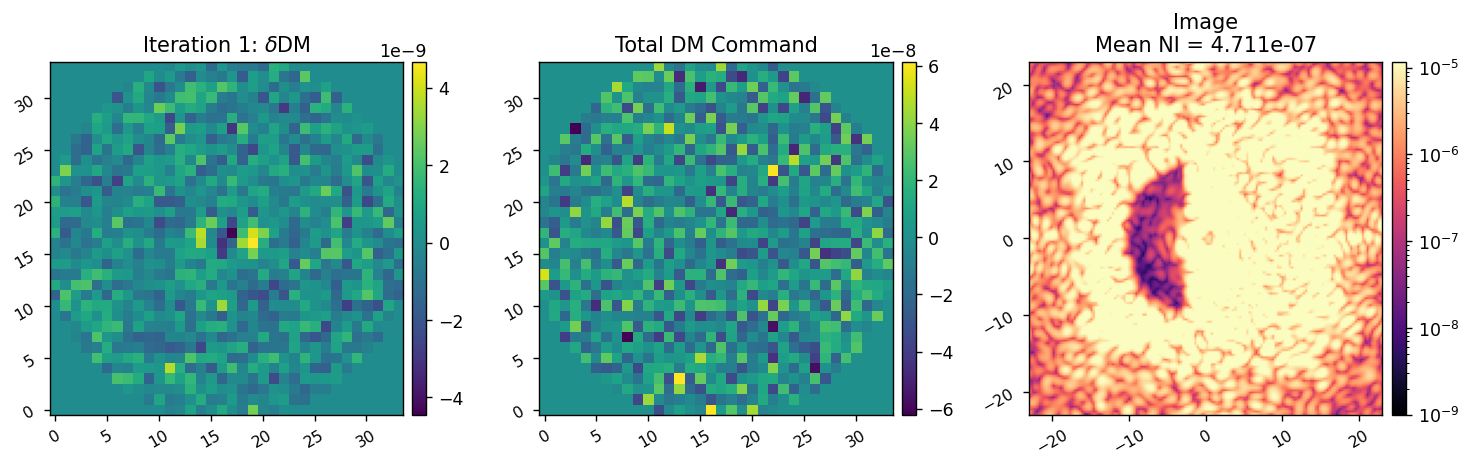

In [123]:
iefc_process.cancel()

In [124]:
I.set_dm(data['commands'][-1])

# Monitor the dark hole

In [ ]:
reload(scoobi)
from pathlib import Path

duration = 1800
# duration = 10
I.NSCICAM = 20

# time.sleep(5)
scoobi.stream_scicam(
    I, 
    duration=duration, 
    control_mask=new_control_mask, 
    # plot=True, 
    clear=True, 
    fname=f'../data/llowfsc+iefc/{today}_camsci_stream_2.pkl',
)

Stopping camsci stream!
Saved data to:  ../data/llowfsc+iefc/20241216_camsci_stream_2.pkl


(1024, 2044) (2044,)


In [238]:
I.zero_dm()

In [126]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


In [125]:
I.zero_dm()


In [5]:
28*137*10

38360